<a href="https://colab.research.google.com/github/ryuaus26/Google-Colab/blob/main/FashionMnist%20with%20Custom%20Functionalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot
import numpy as np
from tqdm import tqdm
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
from keras.layers.core.dense import Dense
class CustomDenseLayer(keras.layers.Layer):
  def __init__(self,units,activation= None):
    super(CustomDenseLayer,self).__init__()
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self,input_shape):
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(initial_value=w_init(shape=(input_shape[-1],self.units),dtype='float32'),trainable=True)
    b_init = tf.zeros_initializer()
    self.b = tf.Variable(initial_value=b_init(shape=(self.units,),dtype='float32'),trainable=True)

  def call(self,inputs):
    if self.activation == tf.nn.softmax:
      return tf.nn.softmax(inputs,axis=-1)
    else:
      return self.activation(tf.matmul(inputs,self.w) + self.b)




def base_model():
  inputs = keras.Input(shape=(784,))
  x = CustomDenseLayer(units=64,activation=tf.nn.relu)(inputs)
  x = CustomDenseLayer(units=64,activation=tf.nn.relu)(x)
  outputs = CustomDenseLayer(units=10,activation=tf.nn.softmax)(x)
  model= keras.Model(inputs=inputs,outputs=outputs)
  return model

train_data = tfds.load('fashion_mnist',split='train')
test_data = tfds.load('fashion_mnist',split='test')

def format_image(data):
  image = data['image']
  # Flattened to a 1D vector of length 784
  image = tf.reshape(image,[-1])
  image = tf.cast(image,'float32')
  image = image/255.0
  return image, data['label']

# the keyword map() applies the function format_image across all the images stored in train_data and test_data variables
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

#Allows for faster data
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test =  test_data.batch(batch_size=batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteV66SE0/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteV66SE0/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
train_metrics = tf.metrics.SparseCategoricalAccuracy()
val_metrics = tf.metrics.SparseCategoricalAccuracy()


In [5]:
model = base_model()
plot_model(model, to_file='custom_model.png', show_shapes=True, show_layer_names=True)

def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)

  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value



def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)

      losses.append(loss_value)

      train_metrics.update_state(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

def perform_validation():
  losses = []
  for (x_val,y_val) in test:
    logits = model(x_val)
    val_loss = loss_object(y_pred=logits,y_true=y_val)
    val_metrics.update_state(y_val,logits)
    losses.append(val_loss)
  return losses
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 custom_dense_layer (CustomD  (None, 64)               50240     
 enseLayer)                                                      
                                                                 
 custom_dense_layer_1 (Custo  (None, 64)               4160      
 mDenseLayer)                                                    
                                                                 
 custom_dense_layer_2 (Custo  (None, 64)               650       
 mDenseLayer)                                                    
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________

In [ ]:
#Start training

EPOCHS = 100
epoch_val_losses, epoch_train_losses = [], []

for epoch in range(EPOCHS):
  print('Start of epoch %d' % (epoch,))

  losses_train = train_data_for_one_epoch()
  train_acc = train_metrics.result()

  losses_val = perform_validation()
  val_acc = val_metrics.result()

  train_acc_on_epoch = []
  val_acc_on_epoch   = []


  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epoch_val_losses.append(losses_val_mean)
  epoch_train_losses.append(losses_train_mean)



  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

  val_metrics.reset_state()
  train_metrics.reset_state()



Start of epoch 0


  0%|          | 0/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_layer_2/Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
Training loss for step 0: 4.1811:   0%|          | 1/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_layer_2/Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
Training loss for step 1: 4.1089:   0%|          | 1/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_layer_2/Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
Training loss for step 2: 3.9485:   0%|          | 2/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_l


 Epoch 0: Train loss: 0.6590  Validation Loss: 0.4888, Train Accuracy: 0.7858, Validation Accuracy 0.8319
Start of epoch 1


  0%|          | 0/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_layer_2/Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
Training loss for step 0: 0.5054:   0%|          | 1/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_layer_2/Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
Training loss for step 1: 0.4048:   0%|          | 1/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_layer_2/Variable:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
Training loss for step 2: 0.3928:   0%|          | 2/938 WARNING:tensorflow:Gradients do not exist for variables ['custom_dense_layer_2/Variable:0', 'custom_dense_l

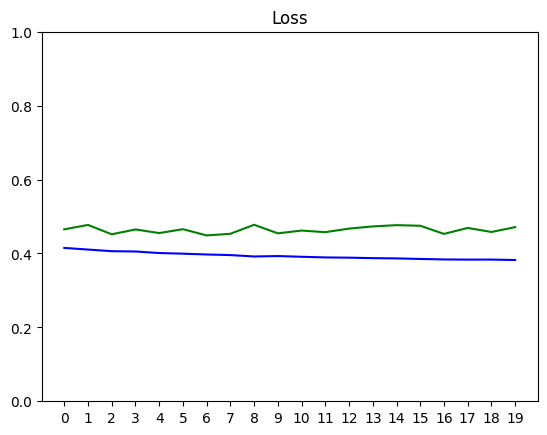

In [21]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epoch_train_losses, epoch_val_losses, "Loss", "Loss", ylim=1.0)

In [22]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)]

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

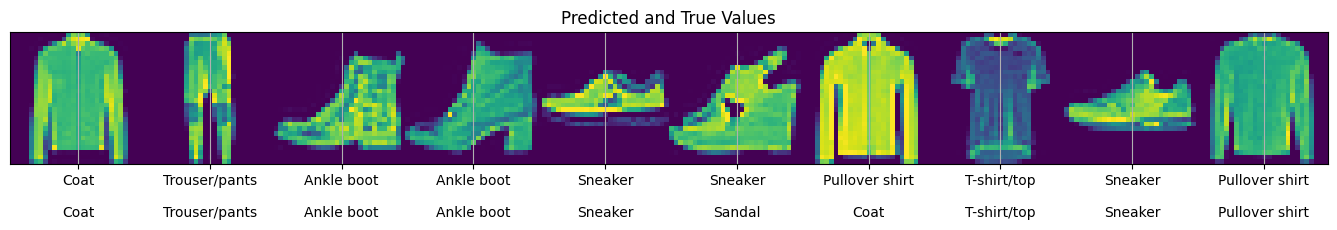

In [24]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)

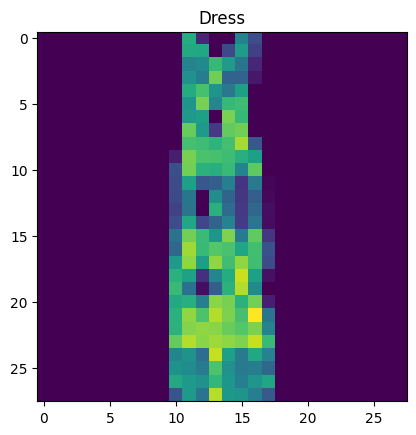

1/1 [==============================] - 0s 19ms/step
Dress


In [91]:
predict_data =  tfds.load('fashion_mnist',split='train')
from keras.utils import img_to_array
predict_data = predict_data.shuffle(buffer_size=1024).batch(batch_size)
i = 0
for image in predict_data:
  if i ==1:
    break

  example = image['image'][0]
  example_flattened = tf.reshape(example, shape=(-1, 784))

  label = image['label'][0]
  i+=1
true_label = class_names[label]
plt.title(true_label)
plt.imshow(example)
plt.show()
prediction = model.predict(example_flattened)
predicted_label = np.argmax(prediction)
predicted_label = class_names[predicted_label]
print(predicted_label)